### I. Library import 


In [19]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install geodatasets

Note: you may need to restart the kernel to use updated packages.


In [21]:
import ipywidgets as widgets
from ipywidgets import interact, interactive,HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

In [41]:
data2 = pd.read_csv("data.csv",low_memory=False)
data1 = pd.read_csv("data2023.csv",low_memory=False)
data = pd.concat([data1, data2], ignore_index=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584106 entries, 0 to 1584105
Data columns (total 15 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   date_mutation              1584106 non-null  object 
 1   nature_mutation            1584106 non-null  object 
 2   valeur_fonciere            1584106 non-null  float64
 3   code_commune               1584106 non-null  object 
 4   code_departement           1584106 non-null  object 
 5   id_parcelle                1584106 non-null  object 
 6   nombre_lots                1584106 non-null  int64  
 7   code_type_local            1584106 non-null  float64
 8   nombre_pieces_principales  1584106 non-null  float64
 9   surface_terrain            1584106 non-null  float64
 10  longitude                  1584106 non-null  float64
 11  latitude                   1584106 non-null  float64
 12  tranche_valeur             1584106 non-null  object 
 13  prix_m2     

### II. Création des fonctions

In [46]:
def selection_filtres_et_analyses(df):
    # **Préparation des filtres**
    type_local_map = {
        1: 'Maison',
        2: 'Appartement',
        3: 'Dépendance (isolée)',
        4: 'Local industriel et commercial ou assimilés'
    }
    df['type_local'] = df['code_type_local'].map(type_local_map)
    
    departements = df['code_departement'].unique()
    types_biens = df['type_local'].unique()
    
    # **Widgets pour les filtres**
    departement_select = widgets.SelectMultiple(
        options=departements,
        value=[],
        description='Départements',
        layout=widgets.Layout(width='60%')
    )
    departement_select.style.description_width = '100px'
    
    type_bien_select = widgets.SelectMultiple(
        options=types_biens,
        value=[],
        description='Types de biens',
        layout=widgets.Layout(width='60%')
    )
    type_bien_select.style.description_width = '100px'
    
    # **Widget pour sélectionner l'analyse à exécuter**
    analyses_disponibles = {
        "Prix moyen par m²": afficher_prix_moyen_par_m2,
        "Surface moyenne" : afficher_surface_moyenne_par_dept,
        "Evolution des prix" : evolution_prix_moyen_par_m2_par_departement_mensuel,
        "Nombre pièces principales" :afficher_nombre_piece_departement,
        "Type de bien par departement" : repartition_type_bien_par_departement,
        "Répartition des valeurs foncières" : repartition_Valeur_fonciere_par_tranche,
        "Prix m² en fonction de la surface" : prix_m2_par_surface
        
    }
    
    analyse_select = widgets.SelectMultiple(
        options=list(analyses_disponibles.keys()),
        description='Analyse',
        layout=widgets.Layout(width='60%')
    )
    
    analyse_select.style.description_width = '100px'
    
    # Bouton pour appliquer les filtres
    bouton_apply = widgets.Button(description="Appliquer les filtres", button_style='success')

    # Fonction pour récupérer les filtres et exécuter l'analyse
    def appliquer_filtres(_):
        selected_analyses = list(analyse_select.value)
        
        # Exécuter chaque analyse sélectionnée
        for analyse in selected_analyses:
            func = analyses_disponibles[analyse]
            func(df, departement_select, type_bien_select)
    
    # Lier le bouton à la fonction
    bouton_apply.on_click(appliquer_filtres)
    
    # Afficher les widgets
    display(departement_select, type_bien_select, analyse_select, bouton_apply)

In [25]:
def afficher_prix_moyen_par_m2(df,departement_select,type_bien_select):

    # Récupérer les départements et types de bien sélectionnés
    selected_departements = list(departement_select.value)
    selected_types_bien = list(type_bien_select.value)

    # Si rien n'est sélectionné, on prend tous les départements et types de biens
    if not selected_departements:
        selected_departements = list(df['code_departement'].unique())
    if not selected_types_bien:
        selected_types_bien = list(df['type_local'].unique())
    
    # Filtrer les données en fonction des départements et types de bien sélectionnés
    df_filtered = df[(df['code_departement'].isin(selected_departements)) & 
                        (df['type_local'].isin(selected_types_bien))].copy()

    # Calculer le prix moyen par m² par département
    prix_moyen_par_dept = df_filtered.groupby('code_departement')['prix_m2'].mean()

    # Calculer la moyenne des prix des départements sélectionnés
    prix_moyen_selectionne = prix_moyen_par_dept.mean()

    # Calculer la moyenne nationale des prix par m²
    prix_moyen_national = df[df['type_local'].isin(selected_types_bien)].groupby('code_departement')['prix_m2'].mean().mean()

    # Création du graphique
    fig, ax = plt.subplots(figsize=(20, 6))

    # Tracer le prix moyen pour chaque département sélectionné
    ax.bar(prix_moyen_par_dept.index, prix_moyen_par_dept)

    # Ajouter une barre pour la moyenne des départements sélectionnés
    ax.bar('Moyenne Sélectionnée', prix_moyen_selectionne, alpha=0.7)

    # Ajouter une barre pour la moyenne nationale
    ax.bar('Moyenne Nationale', prix_moyen_national, alpha=0.7)

    # Paramètres du graphique
    ax.set_ylabel('Prix moyen par m² (€)')
    ax.set_xlabel('Départements')
    ax.set_title("Prix moyen par m² par département, sélection et moyenne globale")
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=90)
    plt.tight_layout()  # Pour éviter que les labels se chevauchent
    plt.show()


In [26]:
def afficher_surface_moyenne_par_dept(df,departement_select,type_bien_select):
    
    # Récupérer les départements et types de bien sélectionnés
    selected_departements = list(departement_select.value)
    selected_types_bien = list(type_bien_select.value)

    # Si rien n'est sélectionné, on prend tous les départements et types de biens
    if not selected_departements:
        selected_departements = list(df['code_departement'].unique())
    if not selected_types_bien:
        selected_types_bien = list(df['type_local'].unique())

    # Filtrer les données en fonction des départements et types de bien sélectionnés
    df_filtered = df[(df['code_departement'].isin(selected_departements)) & 
                        (df['type_local'].isin(selected_types_bien))].copy()

    
    # Calculer la surface moyenne pour chaque département sélectionné
    surface_moyenne_par_dept = df_filtered.groupby('code_departement')['surface_terrain'].mean()

    # Calculer la moyenne des surfaces des départements sélectionnés
    surface_moyenne_selectionnee = surface_moyenne_par_dept.mean()

    # Calculer la surface moyenne nationale (moyenne de tous les départements et types de bien sélectionnés)
    surface_moyenne_nationale = df[df['type_local'].isin(selected_types_bien)].groupby('code_departement')['surface_terrain'].mean().mean()

    # Création du graphique
    fig, ax = plt.subplots(figsize=(20, 6))

    # Tracer la surface moyenne pour chaque département sélectionné
    ax.bar(surface_moyenne_par_dept.index, surface_moyenne_par_dept, label='Surface Moyenne par Département')

    # Ajouter une barre pour la moyenne des départements sélectionnés
    ax.bar('Moyenne Sélectionnée', surface_moyenne_selectionnee, label='Moyenne Sélectionnée', alpha=0.7)

    # Ajouter une barre pour la moyenne nationale
    ax.bar('Moyenne Nationale', surface_moyenne_nationale, label='Moyenne Nationale', alpha=0.7)

    # Paramètres du graphique
    ax.set_ylabel('Surface moyenne en m²')
    ax.set_xlabel('Départements')
    ax.set_title("Surface moyenne en m² par département, sélection et moyenne globale")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Légende", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=90)
    plt.tight_layout()  # Pour éviter que les labels se chevauchent
    plt.show()

In [35]:
def evolution_prix_moyen_par_m2_par_departement_mensuel(df,departement_select,type_bien_select):
    selected_departements = list(departement_select.value)
    selected_types_bien = list(type_bien_select.value)

    if not selected_departements:
        selected_departements = list(df['code_departement'].unique())
    if not selected_types_bien:
        selected_types_bien = list(df['type_local'].unique())

    # Filtrer les données en fonction des départements et types de bien sélectionnés
    df_filtered = df[df['code_departement'].isin(selected_departements) & df['type_local'].isin(selected_types_bien)].copy()

    # S'assurer que la colonne de date est au bon format (si ce n'est pas déjà le cas)
    df_filtered['date_mutation'] = pd.to_datetime(df_filtered['date_mutation'])

    # Groupement par département et par mois
    prix_moyen_par_dept_mois = df_filtered.groupby(['code_departement', 'mois_annee'])['prix_m2'].mean().reset_index()

    # Créer le graphique
    plt.figure(figsize=(15, 8))

    # Ajouter la courbe pour la moyenne générale
    df_dept_global = df_filtered.groupby('mois_annee')['prix_m2'].mean().reset_index()
    plt.plot(df_dept_global['mois_annee'].astype(str), df_dept_global['prix_m2'], marker='o', label='Moyenne générale', linewidth=2)

    # Ajouter la courbe pour la moyenne nationale (basée sur l'intégralité des données)
    df_national_global = df_filtered.groupby('mois_annee')['prix_m2'].mean().reset_index()
    plt.plot(df_national_global['mois_annee'].astype(str), df_national_global['prix_m2'], marker='o', label='Moyenne nationale', linewidth=2)

    # Ajouter les courbes pour chaque département sélectionné
    for departement in selected_departements:
        df_dept = prix_moyen_par_dept_mois[prix_moyen_par_dept_mois['code_departement'] == departement]
        plt.plot(df_dept['mois_annee'].astype(str), df_dept['prix_m2'], marker='o', label=f'Département {departement}')

    plt.title("Évolution du prix moyen par m² par département (mensuel)")
    plt.xlabel("Mois et Année")
    plt.ylabel("Prix moyen par m² (€)")
    plt.legend(title="Types de Bien", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()  # Pour éviter que les labels se chevauchent
    plt.show()

In [28]:
def afficher_nombre_piece_departement(df,departement_select,type_bien_select):
    selected_departements = list(departement_select.value)
    selected_types_bien = list(type_bien_select.value)

    # Si aucun département n'est sélectionné, afficher tous les départements
    if not selected_departements:
        selected_departements = list(df['code_departement'].unique())
    
    # Si aucun type de bien n'est sélectionné, afficher tous les types de bien
    if not selected_types_bien:
        selected_types_bien = list(df['type_local'].unique())

    # Filtrer les données en fonction des départements et types de bien sélectionnés
    df_filtered = df[df['code_departement'].isin(selected_departements) & df['type_local'].isin(selected_types_bien)].copy()

    # Groupement par département pour calculer la moyenne des pièces
    nombre_piece_par_dept = df_filtered.groupby('code_departement')['nombre_pieces_principales'].mean().reset_index()

    # Ajouter la moyenne générale des départements sélectionnés
    moyenne_selection = df_filtered['nombre_pieces_principales'].mean()
    moyenne_nationale = df['nombre_pieces_principales'].mean()

    # Ajouter une barre pour la moyenne générale
    departements = list(nombre_piece_par_dept['code_departement'])
    nombre_piece = list(nombre_piece_par_dept['nombre_pieces_principales'])

    # Créer le graphique
    plt.figure(figsize=(15, 8))
    plt.bar(departements, nombre_piece, color='skyblue')
    plt.axhline(moyenne_selection, color='red', linestyle='dashed', linewidth=2, label='Moyenne Sélectionnée')
    plt.axhline(moyenne_nationale, color='green', linestyle='dashed', linewidth=2, label='Moyenne nationale')

    plt.title("Nombre moyen de pièces par département et par type de bien sélectionné")
    plt.xlabel("Département")
    plt.ylabel("Nombre moyen de pièces")
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()  # Pour éviter que les labels se chevauchent
    plt.show()

In [29]:
def repartition_type_bien_par_departement(df,departement_select,type_bien_select):
    selected_departements = list(departement_select.value)

    if not selected_departements:
        selected_departements = list(df['code_departement'].unique())

    # Filtrer les données pour les départements sélectionnés
    df_filtered = df[df['code_departement'].isin(selected_departements)].copy()

    # Calculer la répartition des types de biens par département
    repartition = df_filtered.groupby(['code_departement', 'type_local']).size().unstack(fill_value=0)

    # Normaliser pour obtenir des proportions (en %)
    repartition_norm = repartition.div(repartition.sum(axis=1), axis=0) * 100

    # Création d'un graphique en barres empilées
    repartition_norm.plot(kind='bar', figsize=(15, 8), stacked=True, colormap='tab20')

    #  option d'affichage du graphique
    plt.title("Répartition des transactions par type de bien et par département")
    plt.xlabel("Département")
    plt.ylabel("Proportion des transactions (%)")
    plt.legend(title="Type de bien", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [30]:
def repartition_Valeur_fonciere_par_tranche(df,departement_select,type_bien_select):
    selected_departements = list(departement_select.value)

    if not selected_departements:
        selected_departements = list(df['code_departement'].unique())

    # Filtrer les données en fonction des départements sélectionnés
    df_filtered = df[df['code_departement'].isin(selected_departements)].copy()

    # Compter le nombre de transactions par tranche et par département
    repartition = df_filtered.groupby(['code_departement', 'tranche_valeur']).size().unstack(fill_value=0)

    # Normaliser pour obtenir des proportions (en %)
    repartition_norm = repartition.div(repartition.sum(axis=1), axis=0) * 100

    # Création du graphique
    repartition_norm.T.plot(kind='bar', figsize=(15, 8), stacked=True, colormap='tab10')

    # option d'affichage du graphique
    plt.title("Répartition des transactions par tranche de valeur foncière et par département")
    plt.xlabel("Tranche de valeur foncière (€)")
    plt.ylabel("Proportion des transactions (%)")
    plt.legend(title="Département", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

In [55]:
def prix_m2_par_surface(df, departement_select, type_bien_select):
    # Récupérer les départements et types de bien sélectionnés
    selected_departements = list(departement_select.value)
    selected_types_biens = list(type_bien_select.value)

    # Si aucun département ou type de bien n'est sélectionné, prendre tout
    if not selected_departements:
        selected_departements = list(df['code_departement'].unique())
    if not selected_types_biens:
        selected_types_biens = list(df['type_local'].unique())

    # Filtrer les données
    df_filtered = df[df['code_departement'].isin(selected_departements) & 
                     df['type_local'].isin(selected_types_biens)].copy()

    # Calculer le prix moyen par plage de surface et département
    prix_moyen_par_surface = df_filtered.groupby(['plage_surface', 'code_departement'])['prix_m2'].mean().reset_index()
    
     # Calculer la moyenne par plage de surface pour la sélection
    moyenne_selection = df_filtered.groupby('plage_surface')['prix_m2'].mean().reset_index()

    # Calculer la moyenne nationale par plage de surface
    moyenne_nationale = df.groupby('plage_surface')['prix_m2'].mean().reset_index()

    # Création du graphique
    plt.figure(figsize=(12, 8))

    for departement in selected_departements:
        df_departement = prix_moyen_par_surface[prix_moyen_par_surface['code_departement'] == departement]
        if not df_departement.empty:
            plt.plot(
                df_departement['plage_surface'], 
                df_departement['prix_m2'], 
                marker='o', 
                label=f'Département {departement}'
            )
    plt.plot(
        moyenne_selection['plage_surface'], 
        moyenne_selection['prix_m2'], 
        marker='o', 
        linestyle='--', 
        label='Moyenne sélectionnée', 
        color='black'
    )

    # Ajouter la courbe de la moyenne nationale
    plt.plot(
        moyenne_nationale['plage_surface'], 
        moyenne_nationale['prix_m2'], 
        marker='o', 
        linestyle=':', 
        label='Moyenne nationale', 
        color='red'
    )

    # Configurations du graphique
    plt.title("Prix moyen par m² en fonction des plages de surface")
    plt.xlabel("Plage de surface (m²)")
    plt.ylabel("Prix moyen par m² (€)")
    plt.legend(title="Départements", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### III. Exécution des fonctions

SelectMultiple(description='Départements', layout=Layout(width='60%'), options=('01', '02', '03', '04', '05', …

SelectMultiple(description='Types de biens', layout=Layout(width='60%'), options=('Maison', 'Dépendance (isolé…

SelectMultiple(description='Analyse', layout=Layout(width='60%'), options=('Prix moyen par m²', 'Surface moyen…

Button(button_style='success', description='Appliquer les filtres', style=ButtonStyle())

C:\Users\maube\AppData\Local\Temp\ipykernel_12324\2322416248.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


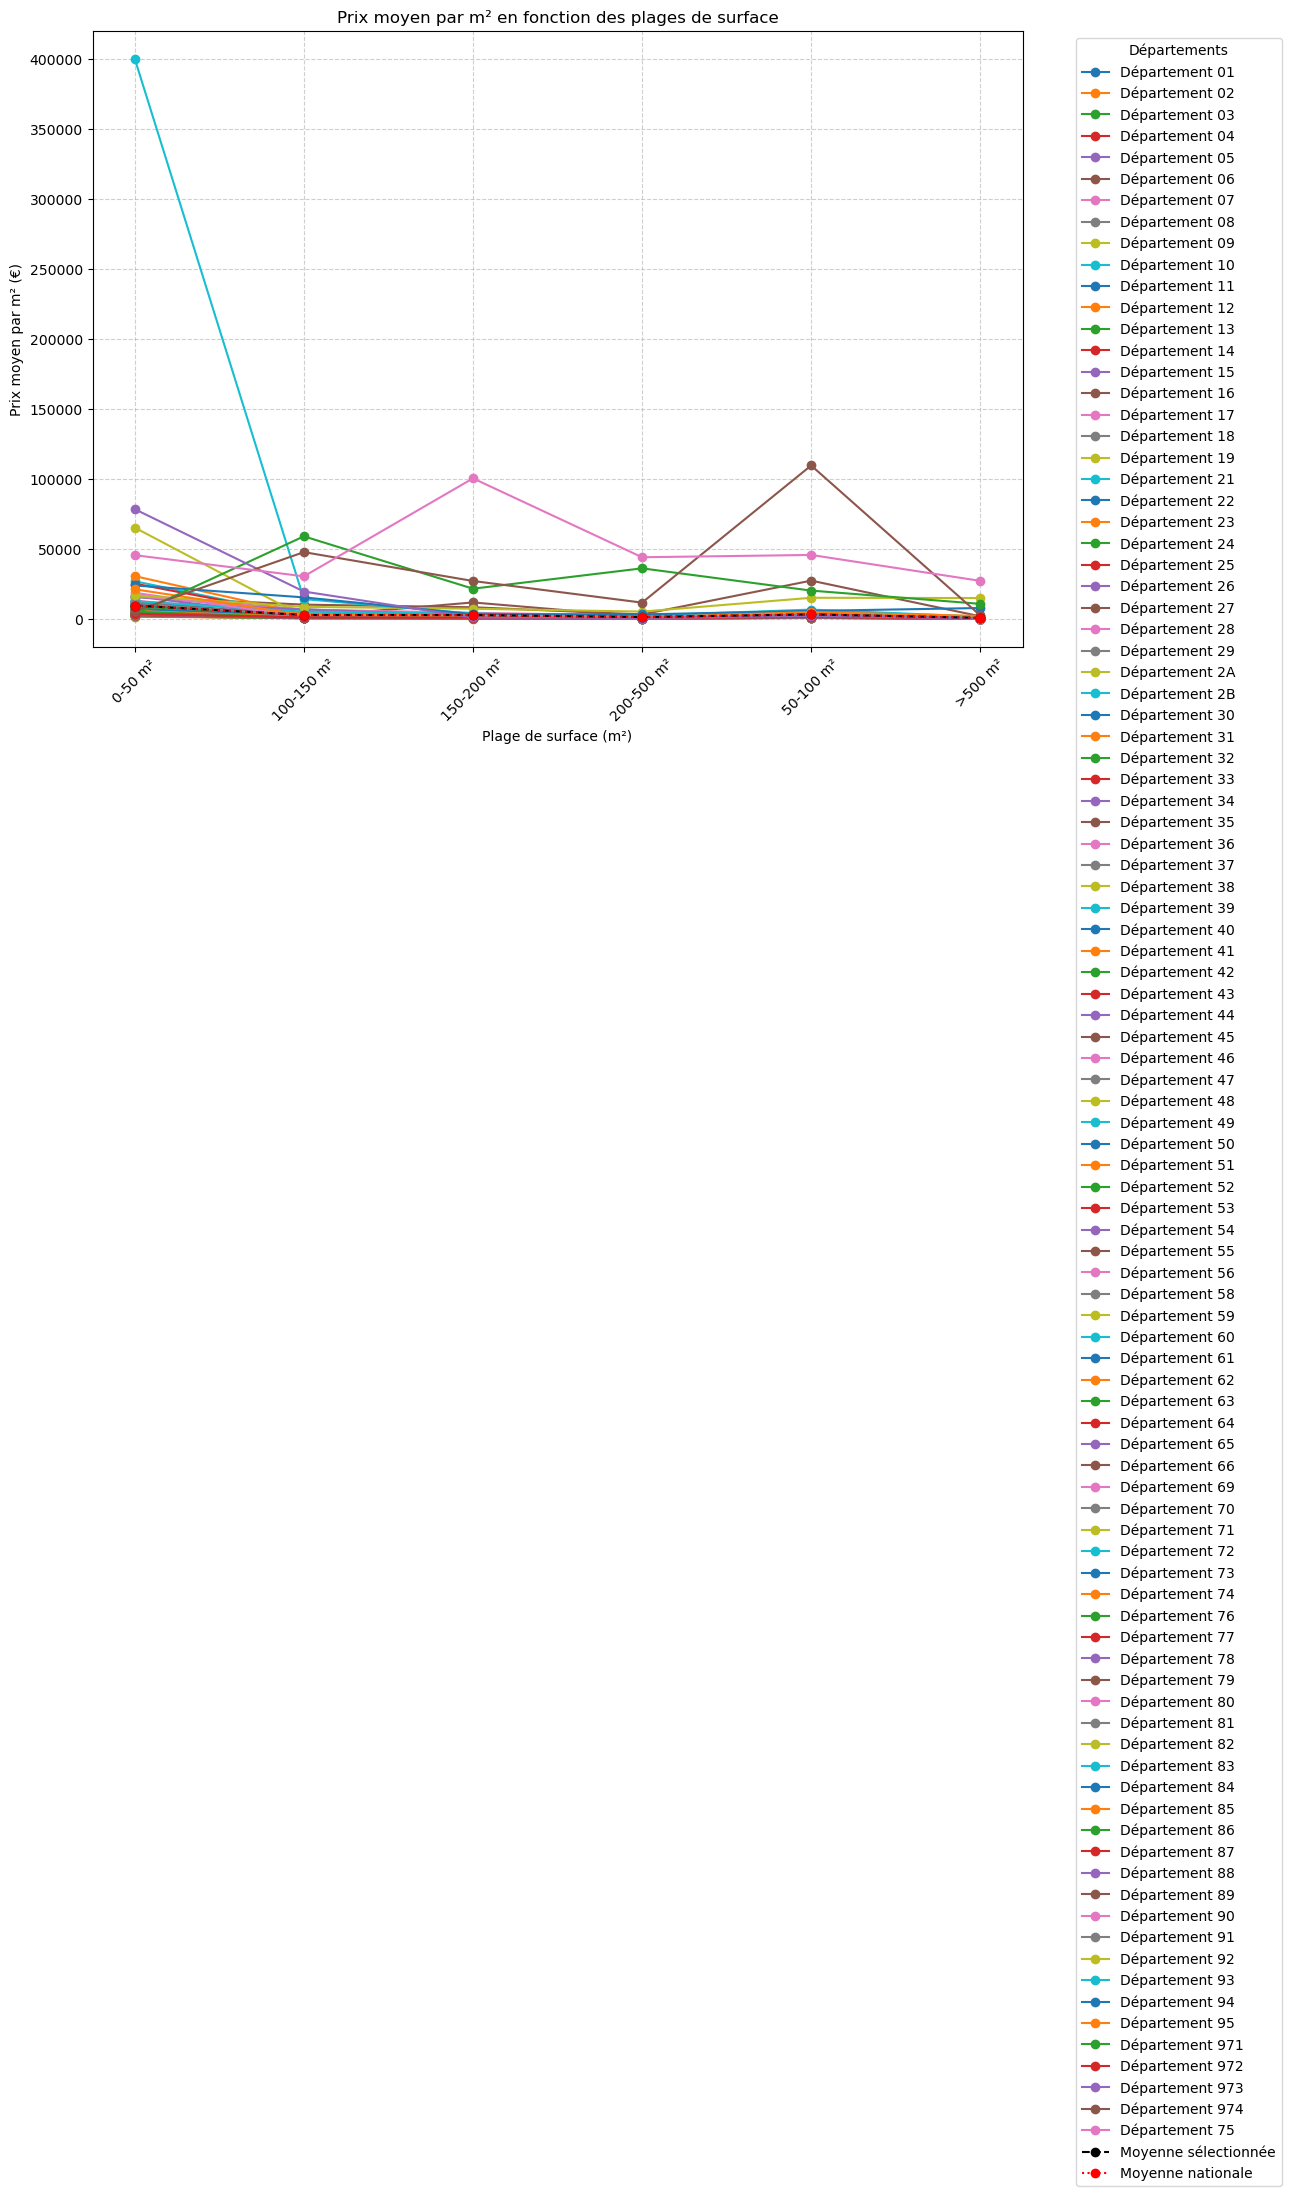

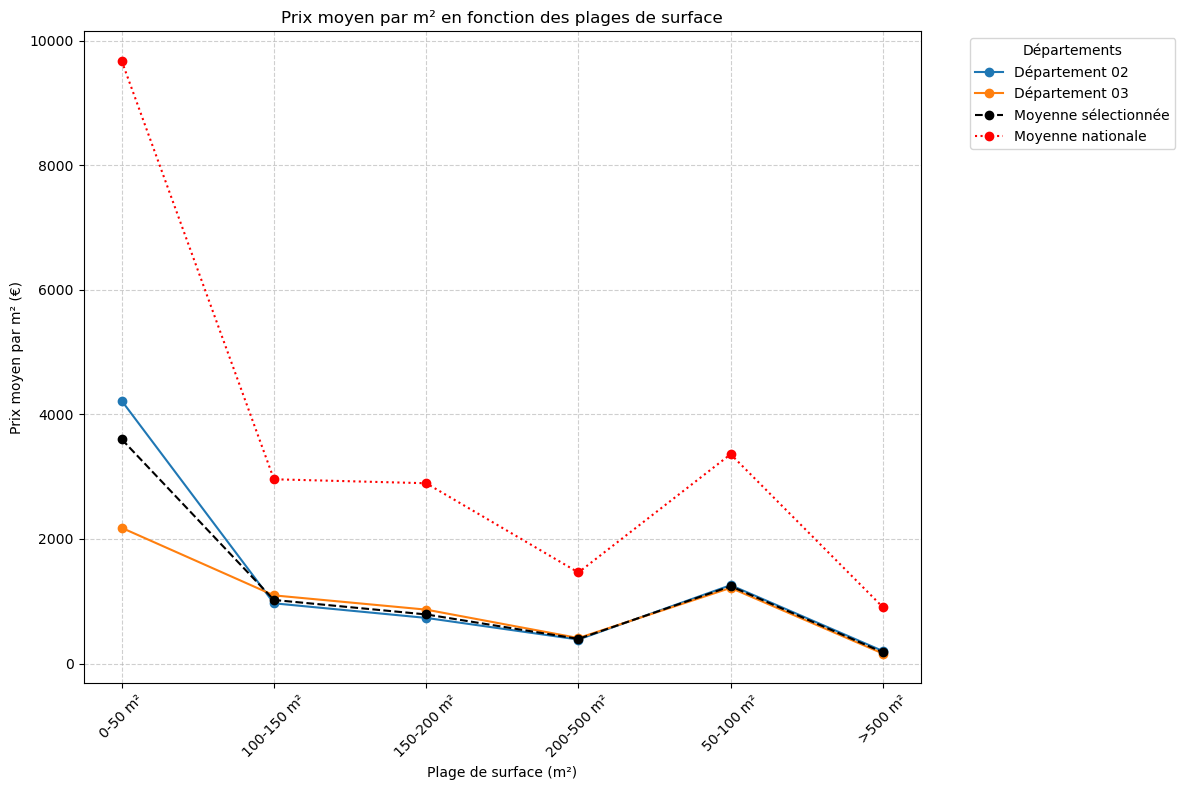

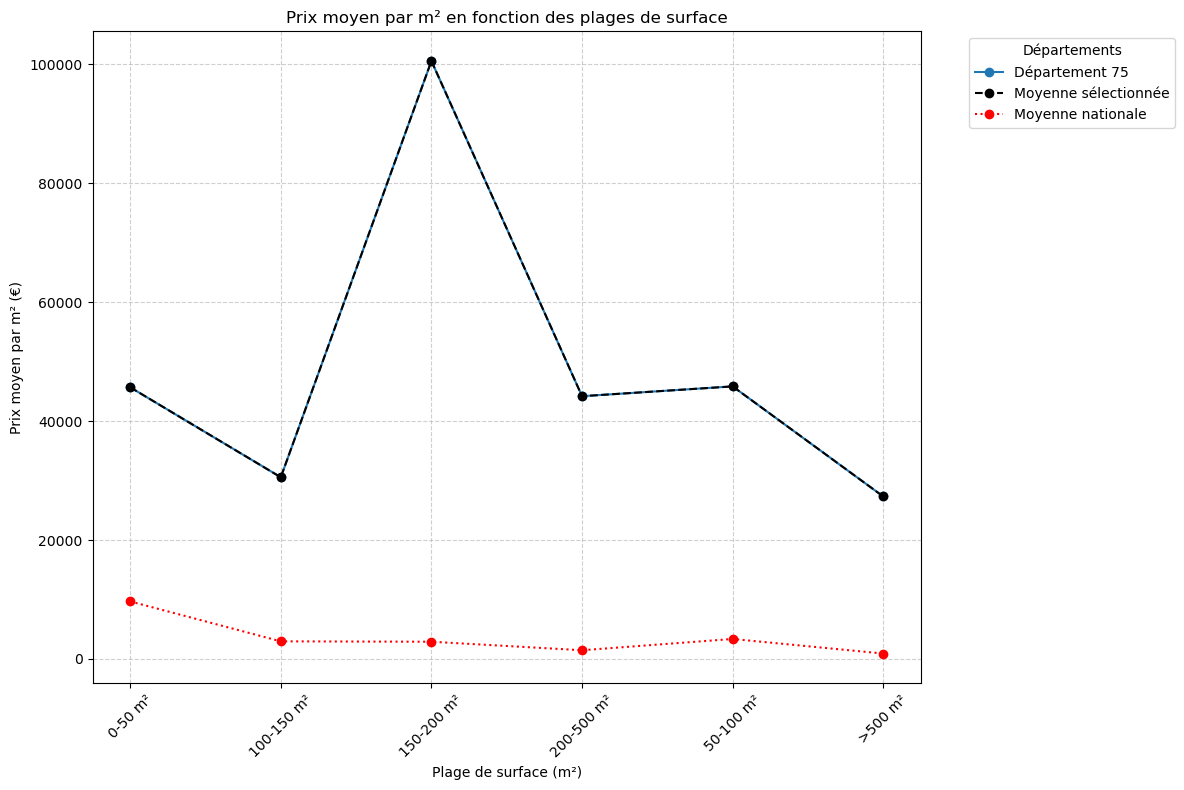

In [56]:
selection_filtres_et_analyses(data)

8732       0.004935
1328454    0.000590
1549515    1.000000
941760     0.004027
890201     0.001354
             ...   
17984      0.001134
1370841    0.000329
314836     0.002893
722605     0.001834
546736     0.046285
Name: valeur_fonciere, Length: 1000, dtype: float64


<Figure size 50000x50000 with 0 Axes>

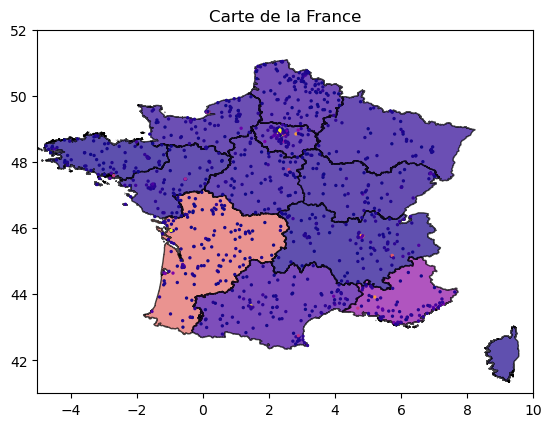

In [32]:
def afficher_carte_france(data):

    chemin_fichier_shp = "regions.shx"
    #ne garder que la france metropolitaine dans le dataset
    metropolitan_departments = [f"{i:02}" for i in range(1, 96)]
    data_metropolitan = data[data['code_departement'].isin(metropolitan_departments)]

    # Charger le fichier shapefile avec geopandas
    carte_france = gpd.read_file(chemin_fichier_shp)

    ratio_average = data_metropolitan.groupby('code_departement')['valeur_fonciere'].mean()

    # Normaliser les valeurs
    ratio_average = (ratio_average - ratio_average.min()) / (ratio_average.max() - ratio_average.min())

    # Transformation logarithmique pour accentuer les différences
    ratio_average = np.log1p(ratio_average * 10)

    # Appliquer la colormap
    face_colors = plt.cm.plasma(ratio_average)


    plt.figure(figsize=(500, 500))


    carte_france.plot(edgecolor='black', facecolor=face_colors, alpha=0.7)
    # ajoute les valeurs fonciere sur la carte avec les coordonnées et color les en fonction du prix 
    sub_data = data_metropolitan.sample(1000)
    #creer une echelle de couleur du bleu au rouge en fonction des valeurs fonciere 




    ratios = (sub_data['valeur_fonciere'] - sub_data['valeur_fonciere'].min()) / (sub_data['valeur_fonciere'].max() - sub_data['valeur_fonciere'].min())
    ratios = np.log1p(ratios * 10)  # Transformation logarithmique
    colors = plt.cm.plasma(ratios)    
    print((sub_data['valeur_fonciere']- sub_data['valeur_fonciere'].min()) / (sub_data['valeur_fonciere'].max() - sub_data['valeur_fonciere'].min()))

    plt.scatter(sub_data['longitude'], sub_data['latitude'], color=colors, s=2)

    #zoom sur la france métropolitaine
    plt.xlim(-5, 10)
    plt.ylim(41, 52)
    plt.title("Carte de la France")
    plt.show()
afficher_carte_france(data)